# CVAE ECG Anomaly Detection Pipeline
Implementación paso a paso en Jupyter Notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

def find_data_subfolder(subfolder_name, start_path='.'):
    current_path = os.path.abspath(start_path)
    while True:
        candidate = os.path.join(current_path, 'data', subfolder_name)
        if os.path.isdir(candidate):
            return candidate
        parent = os.path.dirname(current_path)
        if parent == current_path:
            break
        current_path = parent
    return None

# Ahora buscás las rutas relativas automáticamente:
PTB_DIR = find_data_subfolder('ptb-xl/1.0.3')
CHAP_DIR = find_data_subfolder('ChapmanShaoxing')
MIT_DIR = find_data_subfolder('mitdb')

# Mostrar rutas encontradas
print(f"PTB_DIR: {PTB_DIR}")
print(f"CHAP_DIR: {CHAP_DIR}")
print(f"MIT_DIR: {MIT_DIR}")



PTB_DIR: c:\Users\anapt\Repositorios\TP-final_ML\TP-final_ML\data\ptb-xl/1.0.3
CHAP_DIR: c:\Users\anapt\Repositorios\TP-final_ML\TP-final_ML\data\ChapmanShaoxing
MIT_DIR: c:\Users\anapt\Repositorios\TP-final_ML\TP-final_ML\data\mitdb


In [6]:
from pipeline import main, load, anomalos_ptb, anomalos_chap, metrics, metrics_fixed_threshold, load_sanos, training

In [7]:
data = load_sanos()

Cargando sanos PTB-XL y Chapman…
Total sanos disponibles: 11716 señales


In [8]:
model, val_loader, device= training(data) 

Iniciando entrenamiento…


Ep 1/18 Train:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.9950 — Val MAE=0.6020


Ep 2/18 Train:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.9914 — Val MAE=0.6020


Ep 3/18 Train:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.9914 — Val MAE=0.6020


Ep 4/18 Train:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.9914 — Val MAE=0.6020


Ep 5/18 Train:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.9914 — Val MAE=0.6020


Ep 6/18 Train:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.9914 — Val MAE=0.6020


Ep 7/18 Train:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.9914 — Val MAE=0.6020


Ep 8/18 Train:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.9914 — Val MAE=0.6020


Ep 9/18 Train:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.9914 — Val MAE=0.6020


Ep 10/18 Train:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.9914 — Val MAE=0.6020


Ep 11/18 Train:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.9914 — Val MAE=0.6020


Ep 12/18 Train:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.9914 — Val MAE=0.6020


Ep 13/18 Train:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.9914 — Val MAE=0.6020


Ep 14/18 Train:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.9914 — Val MAE=0.6020


Ep 15/18 Train:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.9914 — Val MAE=0.6020


Ep 16/18 Train:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 16: Train Loss=0.9914 — Val MAE=0.6020


Ep 17/18 Train:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 17: Train Loss=0.9914 — Val MAE=0.6020


Ep 18/18 Train:   0%|          | 0/293 [00:00<?, ?it/s]

Epoch 18: Train Loss=0.9914 — Val MAE=0.6020


In [29]:
df_meta, healthy_errors, thr = load(model, val_loader, device)

Cargando metadata PTB-XL para anomalías…
Threshold @12pct de sanos: 0.5110


In [10]:
ptb_errors = anomalos_ptb(df_meta, model, device)

Anómalos PTB-XL: 12285 señales


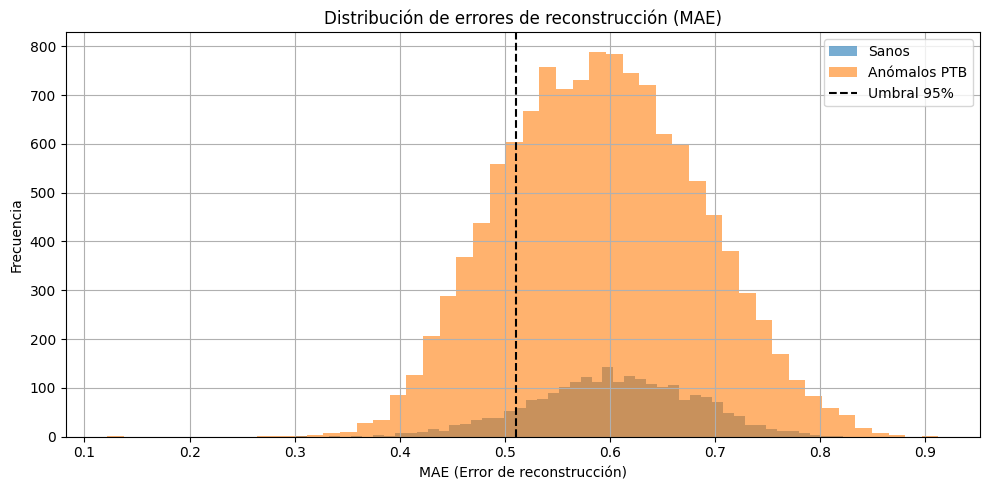

In [30]:
import matplotlib.pyplot as plt
import numpy as np


# 3. Visualizar distribución de errores
plt.figure(figsize=(10,5))
plt.hist(healthy_errors, bins=50, alpha=0.6, label='Sanos')
plt.hist(ptb_errors,    bins=50, alpha=0.6, label='Anómalos PTB')
plt.axvline(thr, color='k', linestyle='--', label='Umbral 95%')
plt.xlabel('MAE (Error de reconstrucción)')
plt.ylabel('Frecuencia')
plt.title('Distribución de errores de reconstrucción (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
chap_errors = anomalos_chap(model, device)

Anómalos Chapman: 8045 señales


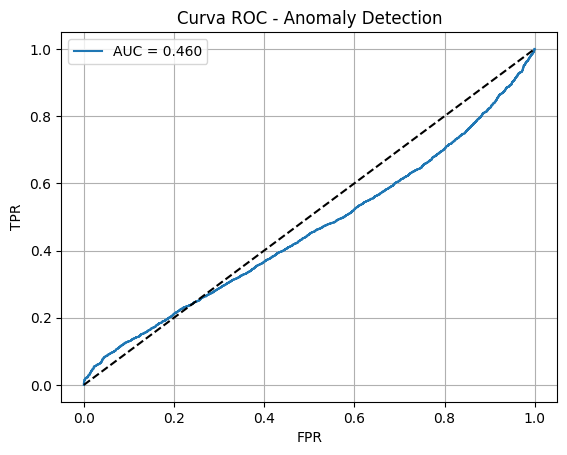

In [31]:
from sklearn.metrics import roc_curve, auc

y_true = np.concatenate([
    np.zeros_like(healthy_errors),
    np.ones_like(ptb_errors),
    np.ones_like(chap_errors)
])
y_scores = np.concatenate([
    healthy_errors,
    ptb_errors,
    chap_errors
])

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC - Anomaly Detection')
plt.legend()
plt.grid(True)
plt.show()


ES UNA PORONGA!!

In [28]:
from sklearn.metrics import f1_score

best_f1 = 0
best_thr = None
for t in thresholds:
    y_pred = y_scores > t
    f1 = f1_score(y_true, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = t

print(f"🔍 Mejor threshold por F1: {best_thr:.4f} — F1: {best_f1:.4f}")


🔍 Mejor threshold por F1: 0.1216 — F1: 0.9455


In [32]:
metrics_fixed_threshold(healthy_errors, ptb_errors, chap_errors, thr)

Métricas (con umbral percentil 12 de sanos): {'precision': 0.887059598287784, 'recall': 0.7950811608460403, 'f1': 0.8385557169537249, 'auc': np.float64(0.4583600426509331)}
Resultados guardados en metrics_combined_lead_II.json
